In [3]:
import pandas as pd
import numpy as np
import torch

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    runs_on_gpu = True
    from google.colab import drive
    drive.mount('/content/drive')
    directory = '/drive/MyDrive/'
else:
    device = torch.device('cpu')
    runs_on_gpu = False
    directory = ''
print(f"Runs on {device.type}")

Runs on cpu


In [5]:
data = pd.read_json('preprocessed_recipes.json')
print(data.info())
interesting_columns = ['num_categories', 'num_ingredients', 'num_directions', 'numerical_columns']
data.head()

<class 'pandas.core.frame.DataFrame'>
Index: 20100 entries, 0 to 20099
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   directions         20100 non-null  object        
 1   date               20100 non-null  datetime64[ns]
 2   categories         20100 non-null  object        
 3   desc               20100 non-null  object        
 4   rating             20100 non-null  float64       
 5   title              20100 non-null  object        
 6   ingredients        20100 non-null  object        
 7   num_categories     20100 non-null  int64         
 8   num_ingredients    20100 non-null  int64         
 9   num_directions     20100 non-null  int64         
 10  numerical_columns  20100 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(5)
memory usage: 1.8+ MB
None


,directions,date,categories,desc,rating,title,ingredients,num_categories,num_ingredients,num_directions,numerical_columns
0,"1. Place the stock, lentils, celery, carrot, t...",2006-09-01 04:00:00,"[Sandwich, Bean, Fruit, Tomato, turkey, Vegeta...",,2.500,"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock,...",11,15,3,-0.034044
1,Combine first 9 ingredients in heavy medium sa...,2004-08-20 04:00:00,"[Food Processor, Onion, Pork, Bake, Bastille D...",This uses the same ingredients found in boudin...,4.375,Boudin Blanc Terrine with Red Onion Confit,"[1 1/2 cups whipping cream, 2 medium onions, c...",11,28,5,-0.033669
2,In a large heavy saucepan cook diced fennel an...,2004-08-20 04:00:00,"[Soup/Stew, Dairy, Potato, Vegetable, Fennel, ...",,3.750,Potato and Fennel Soup Hodge,"[1 fennel bulb (sometimes called anise), stalk...",7,6,2,-0.037781
3,Heat oil in heavy large skillet over medium-hi...,2009-03-27 04:00:00,"[Fish, Olive, Tomato, Sauté, Low Fat, Low Cal,...",The Sicilian-style tomato sauce has tons of Me...,5.000,Mahi-Mahi in Tomato Olive Sauce,"[2 tablespoons extra-virgin olive oil, 1 cup c...",17,10,2,-0.000106
4,Preheat oven to 350°F. Lightly grease 8x8x2-in...,2004-08-20 04:00:00,"[Cheese, Dairy, Pasta, Vegetable, Side, Bake, ...",,3.125,Spinach Noodle Casserole,"[1 12-ounce package frozen spinach soufflé, th...",11,6,1,-0.034548


In [6]:
def load_tfidf():
    return pd.read_pickle('tfidf.pkl')

def load_word2vec():
    return np.load("word2vec.npy")

def load_context_embedding():
    embeddings = np.load("context_embedding.npy")
    return embeddings.reshape(embeddings.shape[0], -1)

# 3 Basic Project
The basic project will consist of solving a regression task, comparing the performance obtained using different vectorizations of the documents and at least two different machine learning strategies, as described below. 

You should use the information in the directions and/or desc variables for all steps of the project, possibly combining this information with metadata from other variables. You should use appropriate metrics for evaluating this task. The performance of the different methods should be estimated using a validation methodology, which you should also explain in the documentation. You should provide a description of the methodology used and analyze the performance obtained according to the input variables.
Keep in mind that the goal is to describe the work carried out and critically analyze the results obtained. Support this with graphs or other representations you consider appropriate. There is no need to describe the algorithms used, but you should explain how you tuned their parameters.

## Baseline

In [7]:
mean_rating = np.mean(data['rating'])
baseline_mse = np.mean((data['rating'] - mean_rating)**2)
print(f"Mean rating: {mean_rating} and MSE: {baseline_mse}")

Mean rating: 3.7130597014925373 and MSE: 1.8039448048934432


In [8]:
most_used_rating = 4.375
mse = np.mean((data['rating'] - most_used_rating)**2)
print(f"MSE: {mse}")

MSE: 2.242109763681592


## 3.4
Training and evaluation of regression models using at least the following two machine learning strategies:
- Neural networks using PyTorch for implementation.
- At least one other technique implemented in the Scikit-learn library
(e.g., K-NN, SVM, Random Forest, etc.)

### Neural networks using PyTorch for implementation.

In [27]:
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import seaborn as sns

In [62]:
class Model(nn.Module):
    def __init__(self, input_size):
        super(Model, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, int(input_size/2)),
            nn.ReLU(),
            nn.Linear(int(input_size/2), 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        
    def forward(self, x):
        return self.linear_relu_stack(x)

In [63]:
X = load_word2vec()
X = np.concatenate((X, data[interesting_columns]), axis=1)

In [64]:
def print_state(epoch, num_epochs, loss, model, X_test, y_test, criterion, hist):
    print(f'Epoch {epoch}/{num_epochs}')
    print(f'-- Loss: {loss.item():.4f}')

    with torch.no_grad():
        model.eval()
        test_outputs = torch.round(model(X_test))
    
    test_loss = criterion(test_outputs, y_test)
    print(f'-- Final test mse: {test_loss.item():.4f}')
    print(f"-- Compared to baseline mse: {baseline_mse / test_loss * 100:.0f}%")
    hist[0].append(loss.item())
    hist[1].append(test_loss.item())

def neural_network(X, y):
    hist = (list(), list())
    X_train, X_test, y_train, y_test = list(map(lambda x: torch.FloatTensor(x), train_test_split(X, y, test_size=0.2, random_state=42)))
    y_train = torch.FloatTensor(y_train).unsqueeze(1)
    y_test = torch.FloatTensor(y_test).unsqueeze(1)

    model = Model(X_train.shape[1])

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 10000
    for epoch in range(num_epochs):
        outputs = model(X_train)
        
        loss = criterion(outputs, y_train)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch % 100 == 0):
            print_state(epoch, num_epochs, loss, model, X_test, y_test, criterion, hist)

    print_state(epoch, num_epochs, loss, model, X_test, y_test, criterion, hist)
    return hist
    

In [65]:
hist = neural_network(X, data['rating'].to_numpy())

Epoch 0/10000
-- Loss: 16.0652
-- Final test mse: 15.4966
-- Compared to baseline mse: 12%
Epoch 100/10000
-- Loss: 1.8750
-- Final test mse: 2.0118
-- Compared to baseline mse: 90%
Epoch 200/10000
-- Loss: 1.6868
-- Final test mse: 1.7819
-- Compared to baseline mse: 101%
Epoch 300/10000
-- Loss: 1.6429
-- Final test mse: 1.7628
-- Compared to baseline mse: 102%


KeyboardInterrupt: 

<Axes: >

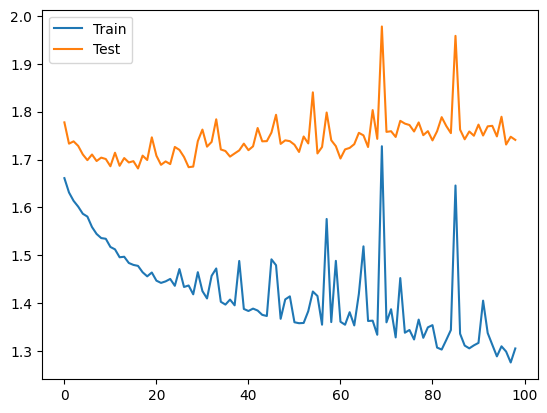

In [61]:
sns.lineplot(x=range(len(hist[0][2:])), y=hist[0][2:], label='Train')
sns.lineplot(x=range(len(hist[1][2:])), y=hist[1][2:], label='Test')

### - At least one other technique implemented in the Scikit-learn library
(e.g., K-NN, SVM, Random Forest, etc.)

In [70]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score

In [71]:
def fit_and_evaluate(model, X, y):
    scores = cross_val_score(model, X, y, cv=2, scoring='neg_mean_squared_error')
    mean_score = scores.mean() * -1
    print(f'-- Mean MSE: {mean_score}')
    print(f"-- Compared to baseline mse: {baseline_mse / mean_score * 100:.0f}%")

def get_context_embeddings():
    embeddings = np.load("context_embedding.npy")
    embeddings = embeddings.reshape(embeddings.shape[0], -1)
    return embeddings

SVR() with interesting_columns
-- Mean MSE: 1.8940360241305583
-- Compared to baseline mse: 95%
SVR() with tfidf
-- Mean MSE: 1.585610046398831
-- Compared to baseline mse: 114%
SVR() with word2vec
-- Mean MSE: 1.8879442238406843
-- Compared to baseline mse: 96%
SVR() with context_embedding
-- Mean MSE: 1.705611466709691
-- Compared to baseline mse: 106%
RandomForestRegressor() with interesting_columns
-- Mean MSE: 1.8013110940382657
-- Compared to baseline mse: 100%
RandomForestRegressor() with tfidf


KeyboardInterrupt: 

In [ ]:
data_configs = {
    'interesting_columns': data[interesting_columns],
    'tfidf': load_tfidf(),
    'word2vec': load_word2vec(),
    'context_embedding': load_context_embedding(),
}

models = [SVR(), RandomForestRegressor()] 
for model in models:
    for key, X in data_configs.items():
        print(f"{model} with {key}")
        fit_and_evaluate(model, X, data['rating'])

SVR() with interesting_columns
-- Mean MSE: 1.8940360241305583
-- Compared to baseline mse: 95%
SVR() with tfidf
-- Mean MSE: 1.585610046398831
-- Compared to baseline mse: 114%
SVR() with word2vec
-- Mean MSE: 1.8879442238406843
-- Compared to baseline mse: 96%
SVR() with context_embedding
-- Mean MSE: 1.705611466709691
-- Compared to baseline mse: 106%
RandomForestRegressor() with interesting_columns
-- Mean MSE: 1.8013110940382657
-- Compared to baseline mse: 100%
RandomForestRegressor() with tfidf

## 3.5
Comparison of the results obtained in step 3 with fine-tuning a pre-trained model from Hugging Face. In this step, you are asked to use a transformer model with a regression head.

In [11]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split  

In [28]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
X = data['directions'].tolist()
y = data['rating'].to_numpy(dtype='float32')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train = tokenizer(X_train, truncation=True, padding=True, max_length=128)
X_test = tokenizer(X_test, truncation=True, padding=True, max_length=128)

In [30]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = Dataset(X_train, y_train)
test_dataset = Dataset(X_test, y_test)

training_args = TrainingArguments(
    output_dir=directory+'results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01, 
    logging_dir=directory+'logs',
    logging_steps=10,
    report_to=[],
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

Start training


                                        
  0%|          | 0/3015 [05:41<?, ?it/s]         

{'loss': 13.6354, 'grad_norm': 110.56185913085938, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.01}


                                        
  0%|          | 0/3015 [05:44<?, ?it/s]         

{'loss': 12.4936, 'grad_norm': 127.78746032714844, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.02}


                                        
  0%|          | 0/3015 [05:48<?, ?it/s]         

{'loss': 10.6723, 'grad_norm': 95.80782318115234, 'learning_rate': 3e-06, 'epoch': 0.03}


                                        
  0%|          | 0/3015 [05:51<?, ?it/s]         

{'loss': 8.7736, 'grad_norm': 114.6506118774414, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.04}


                                        
  0%|          | 0/3015 [05:55<?, ?it/s]         

{'loss': 7.0099, 'grad_norm': 84.49993896484375, 'learning_rate': 5e-06, 'epoch': 0.05}


KeyboardInterrupt: 

In [ ]:
trainer.train()
model.save_pretrained(directory+'fine-tuned-bert')
tokenizer.save_pretrained(directory+'fine-tuned-bert')

10	4.759500
20	4.596200
30	4.074600
40	3.601100
50	2.927900
60	2.513100
70	2.120000
80	1.463200
90	1.835600
100	1.074400
110	1.972900
120	1.461300
130	1.899600
140	1.938900
150	2.292000
160	1.872600
170	2.307200
180	1.933600
190	1.424500
200	1.509400
210	1.586800
220	1.836600
230	1.557700
240	1.632400
250	1.969700
260	2.230800
270	1.778300
280	1.754300
290	1.196500
300	1.406600
310	1.609700
320	1.870100
330	1.618300
340	1.954900
350	1.549400
360	1.859000
370	1.249100
380	1.589800
390	1.678700
400	1.741700
410	1.400900
420	1.618800
430	1.336800
440	2.447800
450	1.850800
460	1.734400
470	1.921000
480	1.480700
490	1.579100
500	1.990500
510	1.573000
520	1.479700
530	2.043300
540	1.617300
550	1.363900
560	1.558400
570	1.477300
580	1.886400
590	1.468900
600	2.248400
610	1.670100
620	1.643600
630	1.579900
640	2.060900
650	1.977900
660	1.503400
670	1.549900
680	1.771000
690	1.562300
700	1.511200
710	1.377100
720	2.086200
730	1.787400
740	1.807900
750	1.237400
760	1.720100
770	2.090700
780	1.979700
790	1.630400
800	1.679800
810	1.763900
820	1.793200
830	2.009800
840	0.942700
850	1.564700
860	1.839600
870	1.881600
880	1.529500
890	1.846800
900	1.439600
910	2.372700
920	2.105600
930	1.419600
940	1.304600
950	1.831700
960	1.720400
970	1.254000
980	1.254900
990	1.881200
1000	1.566800
1010	1.408300
1020	1.536700
1030	1.366900
1040	1.991900
1050	1.925700
1060	1.355900
1070	1.946600
1080	1.687000
1090	1.416600
1100	1.605900
1110	1.503000
1120	2.018900
1130	1.634700
1140	1.358600
1150	2.086900
1160	1.586500
1170	1.788300
1180	1.412300
1190	1.692000
1200	1.419300
1210	1.708600
1220	1.403500
1230	1.679500
1240	1.564100
1250	1.486100
1260	1.518400
1270	1.908500
1280	1.640100
1290	1.418400
1300	1.767100
1310	1.477200
1320	1.606800
1330	1.931800
1340	1.662900
1350	1.061500
1360	1.663100
1370	1.688200
1380	1.301500
1390	1.184800
1400	1.439600
1410	1.486000
1420	1.344500
1430	1.305700
1440	1.550200
1450	1.611000
1460	1.494300
1470	0.917500
1480	1.561000
1490	1.616100
1500	1.748800
1510	1.644600
1520	1.362600
1530	1.476500
1540	1.219800
1550	1.296100
1560	1.478700
1570	1.424600
1580	1.362100
1590	2.142400
1600	1.426600
1610	1.136900
1620	1.325600
1630	1.400400
1640	1.724100
1650	1.589100
1660	1.700800
1670	1.751100
1680	1.159100
1690	1.135800
1700	1.721500
1710	1.248000
1720	1.430000
1730	1.695100
1740	1.299600
1750	1.287200
1760	1.467800
1770	1.699100
1780	1.662400
1790	1.397900
1800	1.504900
1810	1.798800
1820	1.272500
1830	1.754300
1840	1.743300
1850	1.279200
1860	1.985400
1870	2.155000
1880	1.452800
1890	1.195800
1900	1.809400
1910	1.532700
1920	1.430900
1930	1.797800
1940	1.429000
1950	1.078200
1960	1.589500
1970	1.365400
1980	1.578100
1990	1.612000
2000	1.821400
2010	1.633700
2020	1.188200
2030	1.335900
2040	1.318100
2050	1.176000
2060	1.236900
2070	1.335800
2080	1.150800
2090	1.112700
2100	1.655000
2110	1.604600
2120	1.587000
2130	0.879600
2140	1.292700
2150	1.414900
2160	0.873300
2170	1.559500
2180	1.776100
2190	1.593700
2200	1.119800
2210	1.465400
2220	1.968100
2230	1.014400
2240	1.221700
2250	1.342500
2260	1.071600
2270	1.317800
2280	1.029000
2290	1.558400
2300	1.458600
2310	1.379700
2320	1.182600
2330	1.623100
2340	0.931300
2350	1.685000
2360	0.974200
2370	1.261800
2380	1.745800
2390	1.014900
2400	1.189500
2410	1.727300
2420	1.504600
2430	1.432500
2440	1.064100
2450	1.306000
2460	1.143100
2470	1.287800
2480	1.038200
2490	1.146300
2500	0.981500
2510	1.144800
2520	1.203100
2530	1.311900
2540	1.407600
2550	0.875600
2560	1.554500
2570	1.102300
2580	0.807700
2590	0.897500
2600	1.186600
2610	1.357000
2620	0.773000
2630	1.362100
2640	1.302200
2650	1.299400
2660	1.237400
2670	1.473900
2680	1.299600
2690	1.522500
2700	1.238400
2710	1.365200
2720	1.303200
2730	1.383900
2740	1.268900
2750	1.302600
2760	0.706100
2770	1.342800
2780	1.201400
2790	0.977100
2800	1.239500
2810	1.291500
2820	1.039400
2830	1.454600
2840	1.693900
2850	1.171200
2860	0.780100
2870	1.183500
2880	1.180300
2890	1.401500
2900	1.648700
2910	1.170000
2920	1.188800
2930	1.715400
2940	0.973500
2950	0.963600
2960	1.040900
2970	1.183600
2980	1.135000
2990	1.287700
3000	1.070800
3010	0.864700

In [ ]:
trainer.evaluate()

{'eval_loss': 1.5266793966293335,
 'eval_runtime': 26.9099,
 'eval_samples_per_second': 149.388,
 'eval_steps_per_second': 2.341,
 'epoch': 3.0}